# Gaussian Naïve Bayes Implementation

This notebook demonstrates an implementation of a **Naïve Bayes learning algorithm for classification tasks** from scratch, focusing on the **Gaussian Naïve Bayes classifier** due to the presence of continuous features in the dataset.

## Key Features:
1. **Naïve Bayes Algorithm**:  
   Implements a Gaussian Naïve Bayes classifier designed to handle datasets with continuous numerical features.

2. **Cross-Validation**:  
   Includes a **10-fold cross-validation test** to evaluate the model's performance, ensuring robust and unbiased results.

3. **ROC Curve and AUC Evaluation**:  
   - Plots the **average Receiver Operating Characteristic (ROC)** curve from the cross-validation process.  
   - Computes the **average area under the ROC curve (AUC)** value to assess classification performance.

## Dataset:
The model is evaluated on modified versions of the Iris dataset, a classic dataset commonly used in machine learning tasks. For experimentation:  
- The dataset is altered to include only two of the three classes, leaving 100 instances for classification in each scenario.  
- This setup enables a clear demonstration of binary classification using Gaussian Naïve Bayes.  

The Iris dataset can be downloaded from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris)**.

## Design Choices:  
The project includes explanations for key design decisions, such as handling continuous features and the use of Gaussian probability distributions for modeling.

---

### Formula for Gaussian Naïve Bayes:
The Gaussian Naïve Bayes classifier assumes that continuous values associated with each feature are distributed according to a Gaussian distribution. The formula for the probability density function of a normal distribution is:

$ P(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}} $

where:  
- $ x $: feature value  
- $ \mu $: mean of the feature  
- $ \sigma $: standard deviation of the feature

---
### Prerequisites:
To run this notebook, ensure you have the following Python libraries installed:  
- `numpy`  
- `pandas`  
- `matplotlib`
- `seaborn`

In [ ]:
from csv import reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Naïve Bayes classifier
class NaiveBayes:    
    def _init_(self):        
        self.priors = None
        self.means = None
        self.stds = None

    def fit(self, X, y):        
        n_classes = np.unique(y).size
        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, X.shape[1]))
        self.stds = np.zeros((n_classes, X.shape[1]))
        for c in range(n_classes):
            Xc = X[y == c]
            self.priors[c] = Xc.shape[0] / X.shape[0]
            self.means[c, :] = np.mean(Xc, axis=0)
            self.stds[c, :] = np.std(Xc, axis=0)

    def predict_proba(self, X):        
        n_samples = X.shape[0]
        n_classes = self.priors.shape[0]
        probs = np.zeros((n_samples, n_classes))
        for c in range(n_classes):
            # Calculate the probabilities using a Gaussian distribution
            probs[:, c] = self.priors[c] * np.prod(
                np.exp(-(X - self.means[c, :]) * 2 / (2 * self.stds[c, :] * 2)) / (np.sqrt(2 * np.pi) * self.stds[c, :]),
                axis=1)
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs
        
    def predict(self, X):
        # Return the index of the row with the highest probability
        return np.argmax(self.predict_proba(X), axis=1)

def roc_curve(y_true, y_scores, pos_label=1):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        # Confusion matrix
        tp = sum((y_true == pos_label) & (y_pred == pos_label))
        fp = sum((y_true != pos_label) & (y_pred == pos_label))
        fn = sum((y_true == pos_label) & (y_pred != pos_label))
        tn = sum((y_true != pos_label) & (y_pred != pos_label))
        # Calculate the True Positive Rate and False Positive Rate
        # and add them to the lists.
        tpr.append((tp) / (tp + fn))
        fpr.append((fp) / (fp + tn))
    return fpr, tpr, thresholds

def auc(fpr, tpr):
    # The area under the curve is the sum of areas of the trapezoids
    auc = 0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc

In [285]:
# Define the cross-validation function
def cross_validation(X, y, k=10):
    sns.set()
    plt.figure(figsize=(15,7))
    fold_size = X.shape[0] // k
    tprs,aucs = [],[]
    mean_fpr = np.linspace(0,1,100)
    counter = 1
    for i in range(k):
        # Splitting the training and testing sets
        X_train = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
        y_train = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])
        X_test = X[i * fold_size:(i + 1) * fold_size]
        y_test = y[i * fold_size:(i + 1) * fold_size]
        #
        model = NaiveBayes()
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, thr = roc_curve(y_test, y_scores, pos_label=1)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)        
        plt.plot(fpr, tpr, lw=2, alpha=0.5, label='ROC fold %d (AUC = %0.2f)' % (counter, roc_auc))
        counter += 1
        
    # Plotting the ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='#1E90FF', 
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Diagonal line representing P(x) = 0.5
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black', label="Chance", alpha=.8)
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    # Adding labels and legends
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Data Preparation

We load the data from the given *iris.tmls* file and create one dataset for each scenario.

Scenario 1: Iris-setosa + Iris-versicolor
Scenario 2: Iris-versicolor + Iris-virginica
Scenario 3: Iris-setosa + Iris-virginica

In [286]:
filename = 'iris.tmls'
# df = load_csv(filename)
df = pd.read_csv(filename)
# Remove the line with "r,r,r,r,n"
df = df.drop(df.index[0])

# Create datasets for each scenario and shuffle the data
df1 = df.iloc[:100, :]
df1 = df1.sample(frac=1)
df2 = df.iloc[50: 150, :]
df2 = df2.sample(frac=1)
head = df.iloc[0:50]
tail = df.iloc[100:]
df3 = pd.concat([head, tail], axis=0, ignore_index=True)
df3 = df3.sample(frac=1)

print(df1,df2,df3)


   sepal length sepal width petal length petal width            class
40          5.1         3.4          1.5         0.2      Iris-setosa
6           5.4         3.9          1.7         0.4      Iris-setosa
21          5.4         3.4          1.7         0.2      Iris-setosa
11          5.4         3.7          1.5         0.2      Iris-setosa
85          5.4         3.0          4.5         1.5  Iris-versicolor
..          ...         ...          ...         ...              ...
93          5.8         2.6          4.0         1.2  Iris-versicolor
32          5.4         3.4          1.5         0.4      Iris-setosa
84          6.0         2.7          5.1         1.6  Iris-versicolor
74          6.1         2.8          4.7         1.2  Iris-versicolor
86          6.0         3.4          4.5         1.6  Iris-versicolor

[100 rows x 5 columns]     sepal length sepal width petal length petal width            class
129          6.4         2.8          5.6         2.1   Iris-virg

# Scenario 1
## Iris-setosa + Iris-versicolor

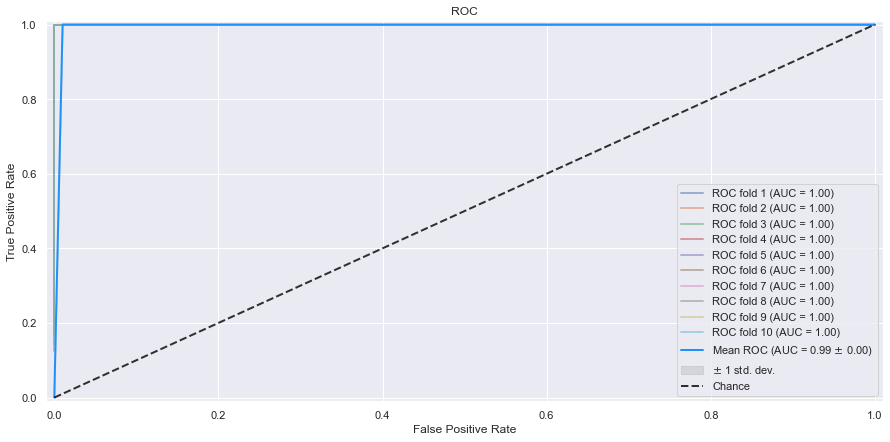

In [287]:
X1 = np.asarray(df1.drop('class', axis=1))
X1 = X1.astype(dtype=np.float64)
y1 = df1['class']
# Replace class names
for i, value in enumerate(np.unique(y1)):
    y1 = np.where(y1 == value, i, y1)
y1 = np.asarray(y1)
y1 = y1.astype(object)
# Run the algorithm
cross_validation(X1, y1, 10)

# Scenario 2
## Iris-versicolor + Iris-virginica

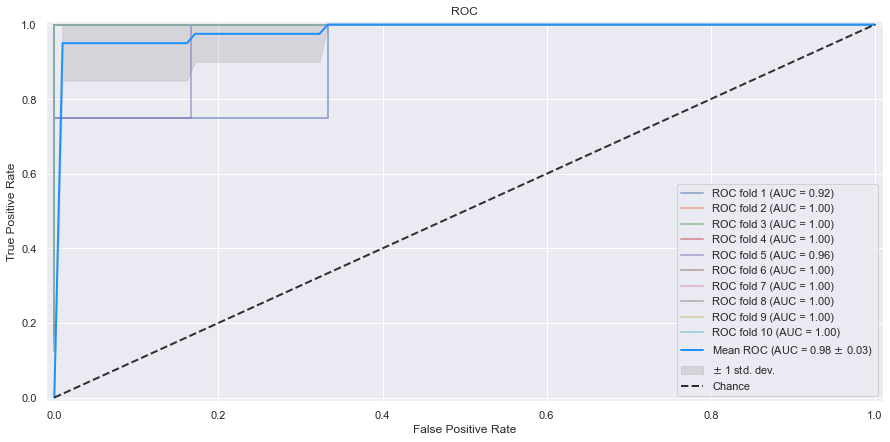

In [288]:
X2 = np.asarray(df2.drop('class', axis=1))
X2 = X2.astype(dtype=np.float64)
y2 = df2['class']
# Replace class names
for i, value in enumerate(np.unique(y2)):
    y2 = np.where(y2 == value, i, y2)
y2 = np.asarray(y2)
y2 = y2.astype(object)
# Run the algorithm
cross_validation(X2, y2, 10)

# Scenario 3
## Iris-setosa + Iris-virginica

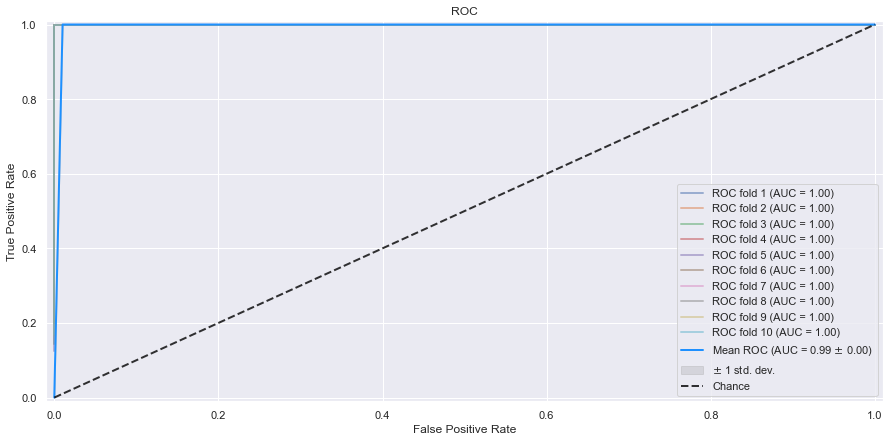

In [289]:
X3 = np.asarray(df3.drop('class', axis=1))
X3 = X3.astype(dtype=np.float64)
y3 = df3['class']
# Replace class names
for i, value in enumerate(np.unique(y3)):
    y3 = np.where(y3 == value, i, y3)
y3 = np.asarray(y3)
y3 = y3.astype(object)
# Run the algorithm
cross_validation(X3, y3, 10)